# Load data 

In [1]:
import torch
import torchvision 
import torchvision.transforms as transoforms
import torch.optim as optim
from documents.load_data import *
# from documents.load_data_SQ import *

from models import *
import torch.nn as nn
import torch.backends.cudnn as cudnn
import os 


%load_ext autoreload
%autoreload 2


device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [2]:
# Data
print(device)
print('==> Preparing data..')
subject="ALL"
load=loader()

train_loader, test_loader,val_loader, _ = load(subject,batch_size= 30,num_validation = 30)

# cc=test_loader 
# dd=val_loader 
# test_loader=dd
# val_loader=cc

sub_num= 4 if subject=="ALL" else subject



cuda
==> Preparing data..
Train data shape:  (1845, 22, 1000)
Train labels shape:  (1845,)
test data shape:  (443, 22, 1000)
test labels shape:  (443,)
Validation data shape:  (270, 22, 1000)
Validation labels shape:  (270,)


In [3]:
# Training 
def train(epoch):
    trainloader=train_loader
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        # Get the inputs
        inputs, labels = inputs.to(device), labels.to(device).long()
        inputs = inputs.to(device)        # Zero the parameter gradients
        optimizer.zero_grad()
    
        # Forward+Backward+Optimize
        outputs = net(inputs)
#         labels = labels.unsqueeze(1)
#         print('labels',labels.shape)
#         one_hot = torch.zeros(labels.shape[0], 4).scatter_(1, labels, 1)       
#         labels=one_hot.to(device)
#         print('outputs',outputs.shape) # Shape should be [20*4]
#         print('labels',labels.shape)
        loss = criterion (outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics 
        train_loss += loss.item()
        _,predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        # progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return ([train_loss/(batch_idx+1),100.*correct/total])


In [4]:
# Testing
def test(epoch, testloader=test_loader):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    total_by_cat = np.zeros((sub_num))
    correct_by_cat = np.zeros((sub_num))


    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(testloader):
#             inputs, labels = inputs.to(device), labels.to(device)
            inputs,labels = inputs.to(device), labels.to(device).long()

            outputs = net(inputs)
#             labels=labels.unsqueeze(1)
            
#             one_hot = torch.zeros(labels.shape[0], 4).scatter_(1, labels, 1)       
#             labels=one_hot.to(device)
            
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            for i, (pred, tar) in enumerate(zip(predicted, labels)):
                total_by_cat[tar.item()]+=1
                if(pred.item() == tar.item()):
                    correct_by_cat[tar.item()] += 1
            #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #    % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))


    print('\nEpoch: %d | Test Loss: %.3f | Acc: %.3f%% (%d/%d)'
        % (epoch, test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    np.set_printoptions(precision=3)
    print("Acc by class: ", correct_by_cat * 1.0 / total_by_cat)

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc

    return [test_loss/(batch_idx+1),100.*correct/total]

In [5]:

# Main 
def main_train(epoches = 8):
    stats = {}
    stats['train'] = []
    stats['val']  = []
    stats['test'] = []
    epoches = range(epoches)
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.97, last_epoch=-1)

    for epoch in epoches:
        scheduler.step()
        stats['train'].append(train(epoch))
        stats['val'].append(test(epoch,testloader=val_loader))

#     stats['test']=test(epoch,test_loader)
#     print('Test set result:',stats['test'])

    stats['val']  = np.array(stats['val'])
    stats['train'] = np.array(stats['train'])

    fig, ax = plt.subplots(1, 2,figsize = (8,4))
    ax[0].plot(epoches,stats['val'][:,0],epoches,stats['train'][:,0])

    ax[0].legend(['validation','train'])
    ax[0].set_title('loss')

    ax[1].plot(epoches,stats['val'][:,1],epoches,stats['train'][:,1])

    ax[1].legend(['validation','train'])
    ax[1].set_title('accuracy')


In [6]:
# Model
from Model import Shallow_CNN
# from models import ShallowCNN,Shallow_CNN_SQ
from models import encoder,Transformer,EncoderRNN,RNN_CNN
from models import RNN_CNN
from models import new_eeg2
net=new_eeg2.EEGNet()
print('==> Building model..')
# net = Shallow_CNN.CNN_Shallow()
# net=encoder.Model() # best59
# net= EncoderRNN.EncoderRNN() 
# net = ShallowCNN.shallow_CNN()
# net = Transformer.Transformer0(cut=20, num_layers=6, heads=4, drop_out=0.1, max_relative_positions=0,)  # best 27 
# 可能是变厚的方式不靠谱，我希望是序列1000个，每20个采一个，也可能是层数太多
# net = Transformer.Transformer1(num_layers=1, heads=8, drop_out=0.1, max_relative_positions=0,) # best 39
# net = Transformer.Transformer1(num_layers=1, heads=1, drop_out=0.1, max_relative_positions=0,) # best 39
# net = Transformer.Transformer1(num_layers=1, heads=1, drop_out=0.5, max_relative_positions=0,) # best 39
# net = EncoderRNN.EncoderRNN() # same as the above encoder.Model() 
# net = EncoderRNN.EncoderRNN1() # best 30
# net = Transformer.Transformer0(cut=10, num_layers=1, heads=4, drop_out=0.1, max_relative_positions=0,) # best 8 epoch 42
# net = Transformer.Transformer0(cut=2, num_layers=1, heads=4, drop_out=0.1, max_relative_positions=0,) #大约10epoch过拟合，最好50
# 不知道是折叠策略不对，还是折叠无效，less is more,放弃折叠
# net = Transformer.Transformer0(cut=1, num_layers=1, heads=2, drop_out=0.1, max_relative_positions=0,) # 只跑了20轮 第19 51
# net = Transformer.Transformer0(cut=1, num_layers=1, heads=1, drop_out=0.1, max_relative_positions=0,) #只跑了20轮 47
# net = Transformer.Transformer0(cut=1, num_layers=1, heads=2, drop_out=0.1, max_relative_positions=20,) # 很慢，第一第二轮都是25
# 怀疑是实现错了

# 以上transformer都还没有调优化器，一般transformer要设置 warmup， 我觉得不设的话lr调小或者decay变大
# net =  RNN_CNN.RNN0_CNN() # 前20轮 14 69.7 
# net =RNN_CNN.RNN0_CNN(rnn_num_layers=1, rnn_dropout=0.3)  # 前20轮18 67 和上面相似，loss在第五个epoch过拟合
# net =RNN_CNN.RNN0_CNN(rnn_num_layers=2, rnn_dropout=0.1) # 感觉这三个acc都波动很大，建议调低lr 13epoch 67
# net =  RNN_CNN.RNN0_CNN(rnn_num_layers=1, rnn_dropout=0) # 把lr调低到0.0001试下，好像在64附近挣扎
# net= Shallow_CNN_SQ.CNN_Shallow()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    
# if args.resume:
#     # Load checkpoint.
#     print('==> Resuming from checkpoint..')
#     assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
#     checkpoint = torch.load('./checkpoint/ckpt.t7')
#     net.load_state_dict(checkpoint['net'])
#     best_acc = checkpoint['acc']
#     # start_epoch = checkpoint['epoch']

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0011, momentum=0.9)


==> Building model..



Epoch: 0 | Test Loss: 1.346 | Acc: 35.185% (95/270)
Acc by class:  [0.221 0.167 0.522 0.493]
Saving..

Epoch: 1 | Test Loss: 1.274 | Acc: 46.296% (125/270)
Acc by class:  [0.221 0.258 0.638 0.731]
Saving..

Epoch: 2 | Test Loss: 1.257 | Acc: 49.630% (134/270)
Acc by class:  [0.324 0.273 0.638 0.746]
Saving..

Epoch: 3 | Test Loss: 1.248 | Acc: 51.111% (138/270)
Acc by class:  [0.412 0.288 0.594 0.746]
Saving..

Epoch: 4 | Test Loss: 1.220 | Acc: 54.444% (147/270)
Acc by class:  [0.426 0.409 0.609 0.731]
Saving..

Epoch: 5 | Test Loss: 1.210 | Acc: 52.963% (143/270)
Acc by class:  [0.456 0.394 0.536 0.731]

Epoch: 6 | Test Loss: 1.205 | Acc: 52.963% (143/270)
Acc by class:  [0.441 0.409 0.594 0.672]

Epoch: 7 | Test Loss: 1.204 | Acc: 51.852% (140/270)
Acc by class:  [0.456 0.364 0.565 0.687]

Epoch: 8 | Test Loss: 1.192 | Acc: 53.333% (144/270)
Acc by class:  [0.471 0.424 0.565 0.672]

Epoch: 9 | Test Loss: 1.191 | Acc: 53.704% (145/270)
Acc by class:  [0.485 0.485 0.507 0.672]

Epoch

Epoch: 84 | Test Loss: 1.095 | Acc: 66.667% (180/270)
Acc by class:  [0.75  0.621 0.565 0.731]

Epoch: 85 | Test Loss: 1.083 | Acc: 69.259% (187/270)
Acc by class:  [0.779 0.621 0.652 0.716]
Saving..

Epoch: 86 | Test Loss: 1.082 | Acc: 68.889% (186/270)
Acc by class:  [0.765 0.591 0.667 0.731]

Epoch: 87 | Test Loss: 1.082 | Acc: 67.037% (181/270)
Acc by class:  [0.691 0.621 0.638 0.731]

Epoch: 88 | Test Loss: 1.089 | Acc: 69.259% (187/270)
Acc by class:  [0.721 0.667 0.652 0.731]

Epoch: 89 | Test Loss: 1.086 | Acc: 68.519% (185/270)
Acc by class:  [0.691 0.576 0.71  0.761]

Epoch: 90 | Test Loss: 1.083 | Acc: 66.296% (179/270)
Acc by class:  [0.676 0.621 0.667 0.687]

Epoch: 91 | Test Loss: 1.085 | Acc: 67.037% (181/270)
Acc by class:  [0.721 0.606 0.652 0.701]

Epoch: 92 | Test Loss: 1.080 | Acc: 69.259% (187/270)
Acc by class:  [0.706 0.697 0.681 0.687]

Epoch: 93 | Test Loss: 1.082 | Acc: 67.407% (182/270)
Acc by class:  [0.721 0.621 0.623 0.731]

Epoch: 94 | Test Loss: 1.096 | 

Epoch: 168 | Test Loss: 1.062 | Acc: 70.000% (189/270)
Acc by class:  [0.691 0.727 0.667 0.716]

Epoch: 169 | Test Loss: 1.069 | Acc: 68.519% (185/270)
Acc by class:  [0.779 0.682 0.623 0.657]

Epoch: 170 | Test Loss: 1.063 | Acc: 71.481% (193/270)
Acc by class:  [0.735 0.742 0.681 0.701]

Epoch: 171 | Test Loss: 1.059 | Acc: 69.630% (188/270)
Acc by class:  [0.779 0.636 0.652 0.716]

Epoch: 172 | Test Loss: 1.065 | Acc: 71.481% (193/270)
Acc by class:  [0.75  0.667 0.696 0.746]

Epoch: 173 | Test Loss: 1.059 | Acc: 71.111% (192/270)
Acc by class:  [0.75  0.682 0.71  0.701]

Epoch: 174 | Test Loss: 1.060 | Acc: 72.222% (195/270)
Acc by class:  [0.794 0.621 0.696 0.776]

Epoch: 175 | Test Loss: 1.063 | Acc: 68.889% (186/270)
Acc by class:  [0.721 0.652 0.652 0.731]

Epoch: 176 | Test Loss: 1.070 | Acc: 71.111% (192/270)
Acc by class:  [0.735 0.742 0.652 0.716]

Epoch: 177 | Test Loss: 1.055 | Acc: 69.630% (188/270)
Acc by class:  [0.735 0.667 0.652 0.731]

Epoch: 178 | Test Loss: 1.061 

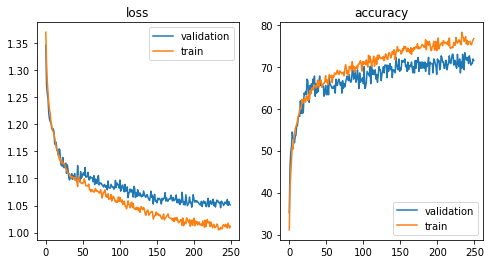

In [7]:
import matplotlib.pyplot as plt
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-08, weight_decay=0.002)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-08, weight_decay=0.01) #SQ

main_train(epoches = 250)

In [13]:
net

DataParallel(
  (module): EEGNet(
    (conv1): Conv2d(1, 4, kernel_size=(1, 125), stride=(1, 1), padding=(0, 62))
    (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (depthwise): Conv2d(4, 8, kernel_size=(22, 1), stride=(1, 1))
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elu): ELU(alpha=0.9, inplace)
    (meanpool1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (dropout): Dropout(p=0.25)
    (pointwise): Conv2d(8, 8, kernel_size=(1, 17), stride=(1, 1), padding=(0, 8))
    (bn3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (meanpool2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (flatten): Flatten()
    (Classifer): Linear(in_features=248, out_features=4, bias=True)
    (softmax): Softmax()
  )
)

how to  

In [14]:
def load_checkpoint(model, checkpoint_PATH, optimizer):
    if checkpoint != None:
        model_CKPT = torch.load(checkpoint_PATH)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
    return model, optimizer

In [15]:
# net,acc,epoch=net.load_state_dict(torch.load('C:/Users/Guangyuan Zhao/Documents/GitHub/ECE239as-Deep-learning/checkpoint/ckpt.t7'))

checkpoint_PATH='D:\Deep learning\checkpoint/ckpt.t7'
model_CKPT = torch.load(checkpoint_PATH)
net.load_state_dict(model_CKPT['net'])



In [16]:
epoch=4
test(epoch,test_loader)



Epoch: 4 | Test Loss: 1.070 | Acc: 69.752% (309/443)
Acc by class:  [0.658 0.732 0.677 0.716]


[1.06992330816057, 69.75169300225734]

In [17]:
# print(model_CKPT['epoch'],model_CKPT['acc'])
print('VAL Acc: %.3f%%'
    % (model_CKPT['acc']))

VAL Acc: 73.333%
